In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/Shareddrives/Data 245 Project/Project Code

/content/drive/Shareddrives/Data 245 Project/Project Code


In [ ]:
!ls

245v2+EDA.ipynb        Project_245_fakejob_raw.ipynb
fake_job_postings.csv  v2.Project_245_fakejob_raw.ipynb
glove.6B.200d.rar      v3.Project_245_fakejob.ipynb
glove.6B.200d.txt


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv('fake_job_postings.csv')

In [ ]:
data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [ ]:
data.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [ ]:
data.fillna("missing", inplace = True) #filling missing values with text 'missing'

In [ ]:
data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,missing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,missing,0,1,0,Other,Internship,missing,missing,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,missing,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,missing,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",missing,missing,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,missing,0,1,0,missing,missing,missing,missing,missing,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,missing,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",missing,missing,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


#### Separating country and city from location

In [ ]:
data['country'] = data['location'].str.split(',').apply(lambda x: x[0])
data['city'] = data['location'].str.split(',').apply(lambda x: x[-1])

In [ ]:
data.head(1)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,city
0,1,Marketing Intern,"US, NY, New York",Marketing,missing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,missing,0,1,0,Other,Internship,missing,missing,Marketing,0,US,New York


#### Separating min and max salary range

In [ ]:
data['min_salary'] = data['salary_range'].str.split('-').apply(lambda x: x[0])
data['max_salary'] = data['salary_range'].str.split('-').apply(lambda x: x[-1])

In [ ]:
data.head(1)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,employment_type,required_experience,required_education,industry,function,fraudulent,country,city,min_salary,max_salary
0,1,Marketing Intern,"US, NY, New York",Marketing,missing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,missing,0,...,Other,Internship,missing,missing,Marketing,0,US,New York,missing,missing


#### Using Natural Language Toolkit for text processing

In [ ]:
import nltk
from nltk import sent_tokenize
from nltk import word_tokenize

import nltk
nltk.download()

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#data['tokenized_description'] = data['description'].apply(word_tokenize)

In [ ]:
#data.head(1)

In [ ]:
#from nltk.probability import FreqDist
#frequency = data['tokenized_description'].apply(FreqDist)

In [ ]:
#frequency

In [ ]:
text_data = data[["title", "company_profile", "description", "requirements", "benefits"]]
text_data = text_data.fillna(' ')

text_data.head()

,title,company_profile,description,requirements,benefits
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,missing
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,missing
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered


In [ ]:
cat_data = data[["telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education", "industry", "function",]]

cat_data.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function
0,0,1,0,Other,Internship,missing,missing,Marketing
1,0,1,0,Full-time,Not Applicable,missing,Marketing and Advertising,Customer Service
2,0,1,0,missing,missing,missing,missing,missing
3,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales
4,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_columns = ['telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function']
lb_make = LabelEncoder()
for i in label_columns:
    cat_data[i] = lb_make.fit_transform(cat_data[i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
cat_data

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function
0,0,1,0,2,4,13,131,22
1,0,1,0,1,6,13,75,7
2,0,1,0,5,7,13,131,37
3,0,1,0,1,5,1,22,31
4,0,1,1,1,5,1,51,16
...,...,...,...,...,...,...,...,...
17875,0,1,1,1,5,13,22,31
17876,0,1,1,1,5,1,61,0
17877,0,0,0,1,7,13,131,37
17878,0,0,1,0,6,6,48,9


# Text Data Processing

In [ ]:
import re
import string

## Look at text columns

In [ ]:
text = text_data[text_data.columns[0:-1]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
target = data['fraudulent']

print(len(text))
print(len(target))
print(text)

17880
17880
0        Marketing Intern,We're Food52, and we've creat...
1        Customer Service - Cloud Video Production,90 S...
2        Commissioning Machinery Assistant (CMA),Valor ...
3        Account Executive - Washington DC,Our passion ...
4        Bill Review Manager,SpotSource Solutions LLC i...
                               ...                        
17875    Account Director - Distribution ,Vend is looki...
17876    Payroll Accountant,WebLinc is the e-commerce p...
17877    Project Cost Control Staff Engineer - Cost Con...
17878    Graphic Designer,missing,Nemsia Studios is loo...
17879    Web Application Developers,Vend is looking for...
Length: 17880, dtype: object


## Function for cleaning up the text data

In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation and remove words containing numbers.'''
    text = text.lower() # Lower case
    text = re.sub('\[.*?\]', '', text) # No text in square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text) # Remove HTML links
    text = re.sub('<.*?>+', '', text) # Remove punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuations
    text = re.sub('\n', '', text) # Remove new lines
    text = re.sub('\w*\d\w*', '', text) # Remove words with numbers
    return text


# Applying the cleaning function to both test and training datasets
text = text.apply(lambda x: clean_text(x))
text.head(10)


0    marketing internwere  and weve created a groun...
1    customer service  cloud video  seconds the wor...
2    commissioning machinery assistant cmavalor ser...
3    account executive  washington dcour passion fo...
4    bill review managerspotsource solutions llc is...
5    accounting clerkmissingjob overviewapex is an ...
6    head of content mffounded in  the fonpit ag ro...
7    lead guest service specialist   airenvy’s miss...
8    hp bsm  is a womanowned small business whose f...
9    customer service associate  part time novitex ...
dtype: object

## Tokenizer

In [ ]:
%%time
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

# appling tokenizer5
text = text.apply(lambda x: tokenizer.tokenize(x))
text.head(3)

CPU times: user 1.68 s, sys: 219 ms, total: 1.9 s
Wall time: 1.91 s


## Removing stopwords in English

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
stop_words = stopwords.words('english')
def remove_stopwords(text):
    """
    Removing stopwords belonging to english language
    
    """
    words = [w for w in text if w not in stop_words]
    return words


text = text.apply(lambda x : remove_stopwords(x))

In [ ]:
text

0        [marketing, internwere, weve, created, groundb...
1        [customer, service, cloud, video, seconds, wor...
2        [commissioning, machinery, assistant, cmavalor...
3        [account, executive, washington, dcour, passio...
4        [bill, review, managerspotsource, solutions, l...
                               ...                        
17875    [account, director, distribution, vend, lookin...
17876    [payroll, accountantweblinc, ecommerce, platfo...
17877    [project, cost, control, staff, engineer, cost...
17878    [graphic, designermissingnemsia, studios, look...
17879    [web, application, developersvend, looking, aw...
Length: 17880, dtype: object

In [ ]:
text.apply(lambda x: [item for item in x if item not in stop])

0        [marketing, internwere, weve, created, groundb...
1        [customer, service, cloud, video, seconds, wor...
2        [commissioning, machinery, assistant, cmavalor...
3        [account, executive, washington, dcour, passio...
4        [bill, review, managerspotsource, solutions, l...
                               ...                        
17875    [account, director, distribution, vend, lookin...
17876    [payroll, accountantweblinc, ecommerce, platfo...
17877    [project, cost, control, staff, engineer, cost...
17878    [graphic, designermissingnemsia, studios, look...
17879    [web, application, developersvend, looking, aw...
Length: 17880, dtype: object

## Lemmatization

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
new_text = pd.DataFrame(text, columns = ['texts'])

In [ ]:
new_text

,texts
0,"[marketing, internwere, weve, created, groundb..."
1,"[customer, service, cloud, video, seconds, wor..."
2,"[commissioning, machinery, assistant, cmavalor..."
3,"[account, executive, washington, dcour, passio..."
4,"[bill, review, managerspotsource, solutions, l..."
...,...
17875,"[account, director, distribution, vend, lookin..."
17876,"[payroll, accountantweblinc, ecommerce, platfo..."
17877,"[project, cost, control, staff, engineer, cost..."
17878,"[graphic, designermissingnemsia, studios, look..."


In [ ]:
tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatization(text):
    return [lemmatizer.lemmatize(x) for x in text]

new_text['text_lemmatized'] = new_text.texts.apply(lemmatization)

In [ ]:
new_text

,texts,text_lemmatized
0,"[marketing, internwere, weve, created, groundb...","[marketing, internwere, weve, created, groundb..."
1,"[customer, service, cloud, video, seconds, wor...","[customer, service, cloud, video, second, worl..."
2,"[commissioning, machinery, assistant, cmavalor...","[commissioning, machinery, assistant, cmavalor..."
3,"[account, executive, washington, dcour, passio...","[account, executive, washington, dcour, passio..."
4,"[bill, review, managerspotsource, solutions, l...","[bill, review, managerspotsource, solution, ll..."
...,...,...
17875,"[account, director, distribution, vend, lookin...","[account, director, distribution, vend, lookin..."
17876,"[payroll, accountantweblinc, ecommerce, platfo...","[payroll, accountantweblinc, ecommerce, platfo..."
17877,"[project, cost, control, staff, engineer, cost...","[project, cost, control, staff, engineer, cost..."
17878,"[graphic, designermissingnemsia, studios, look...","[graphic, designermissingnemsia, studio, looki..."


## Combine Text

In [ ]:
new_text['lemmatize'] = new_text['text_lemmatized'].apply(lambda x: ' '.join(word for word in x))

In [ ]:
new_text

,texts,text_lemmatized,lemmatize
0,"[marketing, internwere, weve, created, groundb...","[marketing, internwere, weve, created, groundb...",marketing internwere weve created groundbreaki...
1,"[customer, service, cloud, video, seconds, wor...","[customer, service, cloud, video, second, worl...",customer service cloud video second world clou...
2,"[commissioning, machinery, assistant, cmavalor...","[commissioning, machinery, assistant, cmavalor...",commissioning machinery assistant cmavalor ser...
3,"[account, executive, washington, dcour, passio...","[account, executive, washington, dcour, passio...",account executive washington dcour passion imp...
4,"[bill, review, managerspotsource, solutions, l...","[bill, review, managerspotsource, solution, ll...",bill review managerspotsource solution llc glo...
...,...,...,...
17875,"[account, director, distribution, vend, lookin...","[account, director, distribution, vend, lookin...",account director distribution vend looking awe...
17876,"[payroll, accountantweblinc, ecommerce, platfo...","[payroll, accountantweblinc, ecommerce, platfo...",payroll accountantweblinc ecommerce platform s...
17877,"[project, cost, control, staff, engineer, cost...","[project, cost, control, staff, engineer, cost...",project cost control staff engineer cost contr...
17878,"[graphic, designermissingnemsia, studios, look...","[graphic, designermissingnemsia, studio, looki...",graphic designermissingnemsia studio looking e...


## Combine Data

In [ ]:
new_data = pd.merge(cat_data, new_text[['lemmatize']], left_index=True, right_index=True)

In [ ]:
new_data = pd.merge(new_data, data[['fraudulent']], left_index=True, right_index=True)

In [ ]:
new_data

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,lemmatize,fraudulent
0,0,1,0,2,4,13,131,22,marketing internwere weve created groundbreaki...,0
1,0,1,0,1,6,13,75,7,customer service cloud video second world clou...,0
2,0,1,0,5,7,13,131,37,commissioning machinery assistant cmavalor ser...,0
3,0,1,0,1,5,1,22,31,account executive washington dcour passion imp...,0
4,0,1,1,1,5,1,51,16,bill review managerspotsource solution llc glo...,0
...,...,...,...,...,...,...,...,...,...,...
17875,0,1,1,1,5,13,22,31,account director distribution vend looking awe...,0
17876,0,1,1,1,5,1,61,0,payroll accountantweblinc ecommerce platform s...,0
17877,0,0,0,1,7,13,131,37,project cost control staff engineer cost contr...,0
17878,0,0,1,0,6,6,48,9,graphic designermissingnemsia studio looking e...,0


In [ ]:
save_data = new_data

## Train Test

In [ ]:
X = new_data.iloc[:, :-1]
y = new_data.iloc[:, -1]

In [ ]:
X

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,lemmatize
0,0,1,0,2,4,13,131,22,marketing internwere weve created groundbreaki...
1,0,1,0,1,6,13,75,7,customer service cloud video second world clou...
2,0,1,0,5,7,13,131,37,commissioning machinery assistant cmavalor ser...
3,0,1,0,1,5,1,22,31,account executive washington dcour passion imp...
4,0,1,1,1,5,1,51,16,bill review managerspotsource solution llc glo...
...,...,...,...,...,...,...,...,...,...
17875,0,1,1,1,5,13,22,31,account director distribution vend looking awe...
17876,0,1,1,1,5,1,61,0,payroll accountantweblinc ecommerce platform s...
17877,0,0,0,1,7,13,131,37,project cost control staff engineer cost contr...
17878,0,0,1,0,6,6,48,9,graphic designermissingnemsia studio looking e...


## Text to numeric using Glove

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

#vectorizer = CountVectorizer()
#vectorizer.fit(z.values.ravel())
#z_train=vectorizer.transform(z.values.ravel())
#z_train=z_train.toarray()

In [ ]:
#z_train

In [ ]:
from sklearn.model_selection import train_test_split

## Unrar

In [ ]:
#!unrar x "glove.6B.200d.rar" "/content/drive/Shareddrives/Data 245 Project/Project Code/"

In [ ]:
embeddings_index = {}
f = open('glove.6B.200d.txt', encoding="utf8")
for line in f:
    values = line.split(' ')
    word = values[0] ## The first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') ## These are the vectors representing the embedding for the word
    embeddings_index[word] = coefs
f.close()

In [ ]:
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
glove_words =  set(embeddings_index.keys())

def convert_sen_to_vec(sentence):
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence
    for word in sentence.split():
        if word in glove_words:
            vector += embeddings_index[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    return vector

In [ ]:
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(200)
    return v / np.sqrt((v ** 2).sum())

In [ ]:
converted_data = []

for i in range(0, new_data.shape[0]):
    converted_data.append(sent2vec(new_data['lemmatize'][i]))

In [ ]:
_1 = pd.DataFrame(converted_data)

In [ ]:
new_data = new_data.drop(columns=['lemmatize'])

In [ ]:
new_data

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0,1,0,2,4,13,131,22,0
1,0,1,0,1,6,13,75,7,0
2,0,1,0,5,7,13,131,37,0
3,0,1,0,1,5,1,22,31,0
4,0,1,1,1,5,1,51,16,0
...,...,...,...,...,...,...,...,...,...
17875,0,1,1,1,5,13,22,31,0
17876,0,1,1,1,5,1,61,0,0
17877,0,0,0,1,7,13,131,37,0
17878,0,0,1,0,6,6,48,9,0


In [ ]:
main_data = pd.concat([_1,new_data], axis=1)

In [ ]:
main_data

,0,1,2,3,4,5,6,7,8,9,...,199,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,-0.002061,0.066000,-0.017966,-0.061503,0.030577,-0.019662,-0.085162,0.000982,-0.030580,0.030815,...,0.015658,0,1,0,2,4,13,131,22,0
1,0.028571,0.063619,-0.053331,-0.056595,0.022424,0.000128,-0.069555,0.009650,0.013362,0.031480,...,0.016425,0,1,0,1,6,13,75,7,0
2,0.031692,0.078740,0.024006,-0.062013,0.007968,-0.018392,-0.071365,0.035503,0.021990,0.008586,...,-0.001151,0,1,0,5,7,13,131,37,0
3,0.040483,0.059467,0.008781,-0.013202,0.032882,-0.009149,-0.084195,0.038128,0.002978,0.056617,...,0.017022,0,1,0,1,5,1,22,31,0
4,0.036627,0.049534,0.018203,-0.034942,0.029900,-0.005607,-0.078676,0.016035,0.003705,0.035780,...,0.006174,0,1,1,1,5,1,51,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,0.052695,0.037381,-0.032322,-0.042386,0.017173,-0.008292,-0.074659,0.007101,-0.000324,0.047896,...,0.026960,0,1,1,1,5,13,22,31,0
17876,0.051455,0.064098,-0.015834,-0.028895,0.040883,-0.026099,-0.067135,0.025180,-0.007879,0.052108,...,0.021530,0,1,1,1,5,1,61,0,0
17877,0.036313,0.027983,0.022579,-0.028348,0.046630,-0.006606,-0.085808,0.003379,0.005933,0.043600,...,-0.001572,0,0,0,1,7,13,131,37,0
17878,0.023673,0.069232,-0.036682,-0.078467,0.079021,-0.016263,-0.117926,0.013720,0.048151,0.027105,...,-0.005863,0,0,1,0,6,6,48,9,0


In [ ]:
main_data.columns = main_data.columns.astype(str)

In [ ]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   telecommuting        17880 non-null  int64
 1   has_company_logo     17880 non-null  int64
 2   has_questions        17880 non-null  int64
 3   employment_type      17880 non-null  int64
 4   required_experience  17880 non-null  int64
 5   required_education   17880 non-null  int64
 6   industry             17880 non-null  int64
 7   function             17880 non-null  int64
 8   fraudulent           17880 non-null  int64
dtypes: int64(9)
memory usage: 1.2 MB


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

main_data[['required_education', 'required_experience', 'employment_type','industry','function']] = StandardScaler().fit_transform(main_data[['required_education', 'required_experience', 'employment_type','industry','function']])

In [ ]:
main_data

,0,1,2,3,4,5,6,7,8,9,...,199,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,-0.002061,0.066000,-0.017966,-0.061503,0.030577,-0.019662,-0.085162,0.000982,-0.030580,0.030815,...,0.015658,0,1,0,0.099313,-0.248399,1.005226,1.308985,-0.145416,0
1,0.028571,0.063619,-0.053331,-0.056595,0.022424,0.000128,-0.069555,0.009650,0.013362,0.031480,...,0.016425,0,1,0,-0.497368,0.537615,1.005226,0.011506,-1.352449,0
2,0.031692,0.078740,0.024006,-0.062013,0.007968,-0.018392,-0.071365,0.035503,0.021990,0.008586,...,-0.001151,0,1,0,1.889358,0.930622,1.005226,1.308985,1.061618,0
3,0.040483,0.059467,0.008781,-0.013202,0.032882,-0.009149,-0.084195,0.038128,0.002978,0.056617,...,0.017022,0,1,0,-0.497368,0.144608,-1.229790,-1.216466,0.578804,0
4,0.036627,0.049534,0.018203,-0.034942,0.029900,-0.005607,-0.078676,0.016035,0.003705,0.035780,...,0.006174,0,1,1,-0.497368,0.144608,-1.229790,-0.544557,-0.628229,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,0.052695,0.037381,-0.032322,-0.042386,0.017173,-0.008292,-0.074659,0.007101,-0.000324,0.047896,...,0.026960,0,1,1,-0.497368,0.144608,1.005226,-1.216466,0.578804,0
17876,0.051455,0.064098,-0.015834,-0.028895,0.040883,-0.026099,-0.067135,0.025180,-0.007879,0.052108,...,0.021530,0,1,1,-0.497368,0.144608,-1.229790,-0.312864,-1.915731,0
17877,0.036313,0.027983,0.022579,-0.028348,0.046630,-0.006606,-0.085808,0.003379,0.005933,0.043600,...,-0.001572,0,0,0,-0.497368,0.930622,1.005226,1.308985,1.061618,0
17878,0.023673,0.069232,-0.036682,-0.078467,0.079021,-0.016263,-0.117926,0.013720,0.048151,0.027105,...,-0.005863,0,0,1,-1.094049,0.537615,-0.298533,-0.614065,-1.191511,0


## Apply SMOTE

In [ ]:
!pip install -U imbalanced-learn

     |████████████████████████████████| 199 kB 5.2 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


In [ ]:
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE

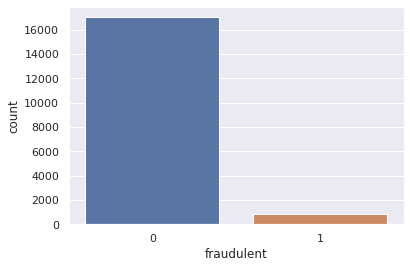

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
sns.countplot(x = "fraudulent" , data = new_data)

In [ ]:
X = main_data.iloc[:, :-1]
Y = main_data.iloc[:, -1]

In [ ]:
print(len(X))
print(len(y))

17880
17880


In [ ]:
oversample = SMOTE()
new_X, new_y = oversample.fit_resample(X, y)

In [ ]:
print(len(new_X))
print(len(new_y))

34028
34028


In [ ]:
new_y.value_counts()

0    17014
1    17014
Name: fraudulent, dtype: int64

#Testing Zone

In [ ]:
test_data = save_data

In [ ]:
save_data

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,lemmatize,fraudulent
0,0,1,0,2,4,13,131,22,marketing internwere weve created groundbreaki...,0
1,0,1,0,1,6,13,75,7,customer service cloud video second world clou...,0
2,0,1,0,5,7,13,131,37,commissioning machinery assistant cmavalor ser...,0
3,0,1,0,1,5,1,22,31,account executive washington dcour passion imp...,0
4,0,1,1,1,5,1,51,16,bill review managerspotsource solution llc glo...,0
...,...,...,...,...,...,...,...,...,...,...
17875,0,1,1,1,5,13,22,31,account director distribution vend looking awe...,0
17876,0,1,1,1,5,1,61,0,payroll accountantweblinc ecommerce platform s...,0
17877,0,0,0,1,7,13,131,37,project cost control staff engineer cost contr...,0
17878,0,0,1,0,6,6,48,9,graphic designermissingnemsia studio looking e...,0


In [ ]:
test_data.drop(test_data.iloc[:, 0:8], inplace = True, axis = 1)

In [ ]:
test_data

,lemmatize,fraudulent
0,marketing internwere weve created groundbreaki...,0
1,customer service cloud video second world clou...,0
2,commissioning machinery assistant cmavalor ser...,0
3,account executive washington dcour passion imp...,0
4,bill review managerspotsource solution llc glo...,0
...,...,...
17875,account director distribution vend looking awe...,0
17876,payroll accountantweblinc ecommerce platform s...,0
17877,project cost control staff engineer cost contr...,0
17878,graphic designermissingnemsia studio looking e...,0


In [ ]:
Xx = test_data.iloc[:, :-1]
Yy = test_data.iloc[:, -1]

In [ ]:
test_data.lemmatize

0        marketing internwere weve created groundbreaki...
1        customer service cloud video second world clou...
2        commissioning machinery assistant cmavalor ser...
3        account executive washington dcour passion imp...
4        bill review managerspotsource solution llc glo...
                               ...                        
17875    account director distribution vend looking awe...
17876    payroll accountantweblinc ecommerce platform s...
17877    project cost control staff engineer cost contr...
17878    graphic designermissingnemsia studio looking e...
17879    web application developersvend looking awesome...
Name: lemmatize, Length: 17880, dtype: object

In [ ]:
X_training, X_testing, y_training, y_testing = train_test_split(test_data.lemmatize, test_data.fraudulent, test_size=0.2, random_state=10)
#oversample = SMOTE()
#the_X, the_y = oversample.fit_resample(X_training, y_training)

In [ ]:
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(X_training)
#transformed test reviews
cv_test_reviews=cv.transform(X_testing)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(X_training)
#transformed test reviews
tv_test_reviews=tv.transform(X_testing)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

In [93]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, roc_auc_score

In [94]:
#training the model
mnb=MultinomialNB()
#fitting the nb for bag of words
mnb_bow=mnb.fit(cv_train_reviews,y_training)
print(mnb_bow)
#fitting the nb for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,y_training)
print(mnb_tfidf)

MultinomialNB()
MultinomialNB()


In [95]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)

In [98]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [99]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(y_testing,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(y_testing,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.9426733780760627
mnb_tfidf_score : 0.9555369127516778


In [100]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [101]:
lr_clfs = LogisticRegression(solver='lbfgs', max_iter=500)
lr_clfs.fit(cv_train_reviews,y_training)

LogisticRegression(max_iter=500)

In [102]:
predictions1 = lr_clfs.predict(cv_test_reviews)
predictions1 = np.round(predictions1).astype(int)
print ("AUC score :", np.round(roc_auc_score(y_testing, predictions1),5))

AUC score : 0.6186


In [103]:
rfcs = RandomForestClassifier(n_estimators=15, min_samples_split = 2, min_samples_leaf = 2, max_depth= 30)
rfcs.fit(cv_train_reviews,y_training)

RandomForestClassifier(max_depth=30, min_samples_leaf=2, n_estimators=15)

In [104]:
predictions2 = rfcs.predict(cv_test_reviews)
predictions2 = np.round(predictions2).astype(int)
print ("AUC score :", np.round(roc_auc_score(y_testing, predictions2),5))

AUC score : 0.5


#End Testing Zone

##Logistic

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
oversample = SMOTE()
lg_X, lg_y = oversample.fit_resample(X_train, y_train)

In [106]:
lr_clf = LogisticRegression(solver='lbfgs', max_iter=500)
lr_clf.fit(lg_X, lg_y)

LogisticRegression(max_iter=500)

In [107]:
from sklearn.metrics import f1_score, roc_auc_score

In [108]:
predictions = lr_clf.predict(X_test)
predictions = np.round(predictions).astype(int)
print ("AUC score :", np.round(roc_auc_score(y_test, predictions),5))

AUC score : 0.82349


## Random Forest

In [109]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [136]:
rfc = RandomForestClassifier(n_estimators=15, min_samples_split = 2, min_samples_leaf = 2, max_depth= 30)
rfc.fit(lg_X, lg_y)

RandomForestClassifier(max_depth=30, min_samples_leaf=2, n_estimators=15)

In [137]:
predictions = rfc.predict(X_test)
predictions = np.round(predictions).astype(int)
print ("AUC score :", np.round(roc_auc_score(y_test, predictions),5))

AUC score : 0.79009


In [139]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, predictions)

print(cf_matrix)

[[3391   25]
 [  66   94]]


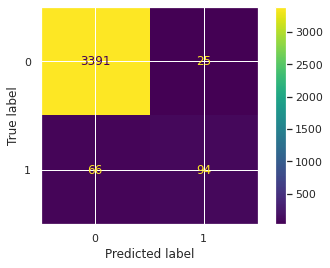

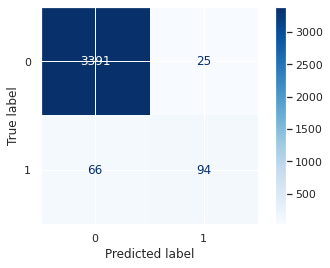

In [149]:
from sklearn.metrics import ConfusionMatrixDisplay


ConfusionMatrixDisplay.from_predictions(y_test,  predictions)
display = display.plot(cmap=plt.cm.Blues)

plt.show()

In [112]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 20, num = 5)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 4,scoring = 'f1')
rf_random.fit(lg_X, lg_y)

RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, None],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [10, 12, 15, 17, 20]},
                   scoring='f1')

## F1 Score

In [113]:
print("Average of the best f1-score in various folds during cross validation = ",rf_random.best_score_)
print("The best parameters found during k-fold cross validation is = ",rf_random.best_params_)

Average of the best f1-score in various folds during cross validation =  0.9875342862648463
The best parameters found during k-fold cross validation is =  {'n_estimators': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}


In [114]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [115]:
print('Tfidf_train : ', X_train.shape)

Tfidf_train :  (14304, 208)


In [116]:
oversample = SMOTE()
new_X, new_y = oversample.fit_resample(X_train, y_train)

In [117]:
print(len(new_X))
print(len(new_y))

27196
27196


In [118]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import sklearn.metrics as metrics

In [135]:
model=GaussianNB()
model.fit(new_X, new_y)
y_pred=model.predict(X_test)
GaussianNB_accuracy = metrics.accuracy_score(y_test, y_pred)
GaussianNB_accuracy

0.70917225950783

## SVM

In [120]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

In [121]:
print('Tfidf_train : ', X_train.shape)

Tfidf_train :  (12516, 208)


In [122]:
oversample = SMOTE()
new_X, new_y = oversample.fit_resample(X_train, y_train)

In [123]:
print(len(new_X))
print(len(new_y))

23820
23820


In [124]:
from sklearn import svm

In [125]:
clf = svm.SVC(kernel='poly', degree=8.7)
clf.fit(new_X, new_y)
y_pred = clf.predict(X_test)

In [126]:
from sklearn import metrics
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred),2))

Accuracy: 0.89


# KNN

In [127]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)

In [128]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
oversample = SMOTE()
lg_X, lg_y = oversample.fit_resample(X_train, y_train)

In [129]:
KNN = knn.fit(lg_X, lg_y)
y_pred = KNN.predict(X_test)


In [130]:
from sklearn import metrics
print("Accuracy with KNN:",round(metrics.accuracy_score(y_test, y_pred),2))
print ("AUC score with KNN:", np.round(roc_auc_score(y_test, y_pred),5))

Accuracy with KNN: 0.94
AUC score with KNN: 0.86057
